In [1]:
import os
import cv2
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [2]:
sample_size = 2000
width = 160
height = 160

In [5]:
files = ['bread-edible', 'bread-inedible','donut-edible', 'pizza-inedible', 'rice-edible']
file_path = "D:\TITO\Documents\Deep-learning\FOODITION-FOOD-EDIBLE-CLASSIFICATION\dataset\{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)

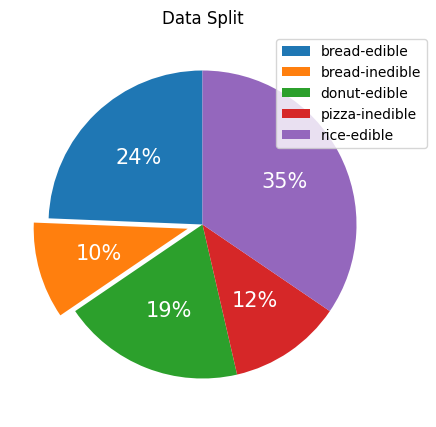

In [8]:
sizes = [len(data['bread-edible']), len(data['bread-inedible']), len(data['donut-edible']), len(data['pizza-inedible']), len(data['rice-edible'])]
explode = (0, 0.1, 0, 0, 0)  

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [9]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class rice-edible
Calculate Time 33.57223


In [10]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(2356, 160, 160, 3)

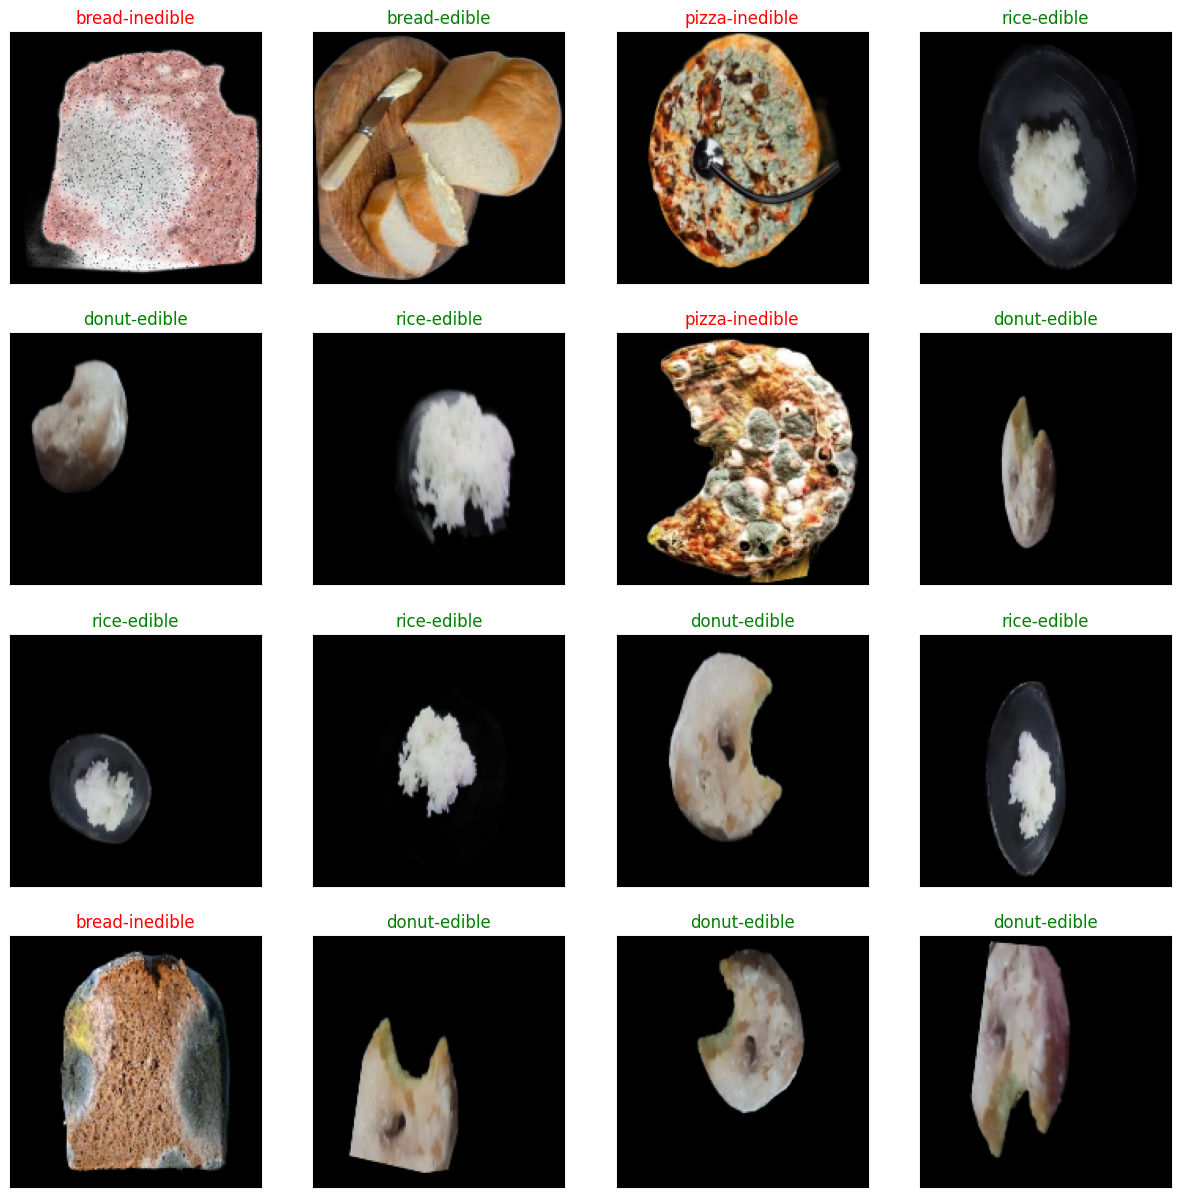

In [12]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if '-edible' in image_target[fig]:
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [13]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [14]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [19]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=10,
                                                restore_best_weights=True)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
52/52 [==============================] - 25s 417ms/step - loss: 0.4482 - accuracy: 0.8381 - categorical_accuracy: 0.2553 - val_loss: 0.0697 - val_accuracy: 0.9788 - val_categorical_accuracy: 0.2249 - lr: 0.0010
Epoch 2/50
52/52 [==============================] - 18s 354ms/step - loss: 0.1193 - accuracy: 0.9582 - categorical_accuracy: 0.2644 - val_loss: 0.0390 - val_accuracy: 0.9844 - val_categorical_accuracy: 0.2093 - lr: 9.0484e-04
Epoch 3/50
52/52 [==============================] - 18s 356ms/step - loss: 0.0715 - accuracy: 0.9806 - categorical_accuracy: 0.2589 - val_loss: 0.0301 - val_accuracy: 0.9873 - val_categorical_accuracy: 0.2164 - lr: 8.1873e-04
Epoch 4/50
52/52 [==============================] - 20s 385ms/step - loss: 0.0538 - accuracy: 0.9842 - categorical_accuracy: 0.2583 - val_loss: 0.0265 - val_accuracy: 0.9915 - val_categorical_accuracy: 0.2079 - lr: 7.4082e-04
Epoch 5/50
52/52 [==============================] - 19s 376ms/step - loss: 0.0467 - accuracy: 0.9836

23/23 - 6s - loss: 0.0136 - accuracy: 0.9958 - categorical_accuracy: 0.2051 - 6s/epoch - 268ms/step


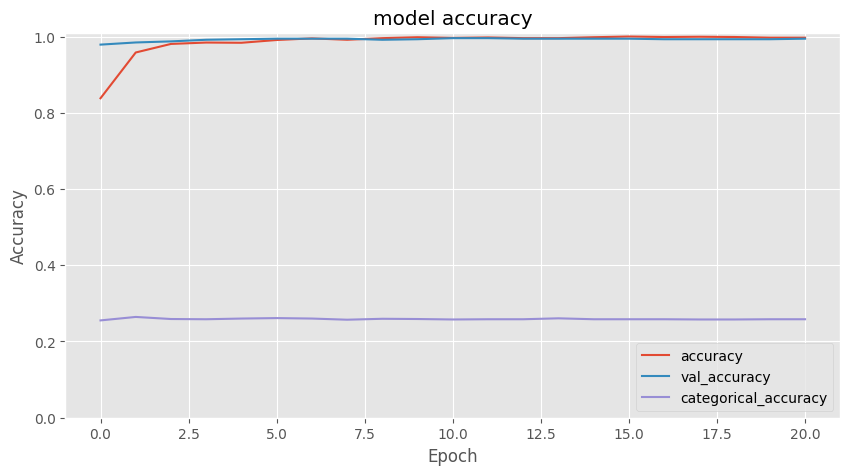

In [22]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

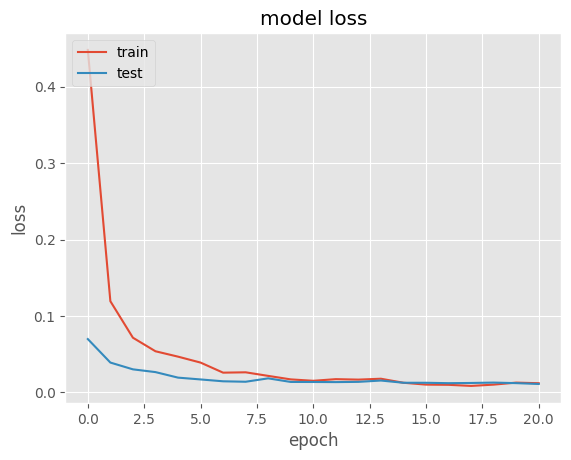

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

23/23 [==============================] - 7s 259ms/step


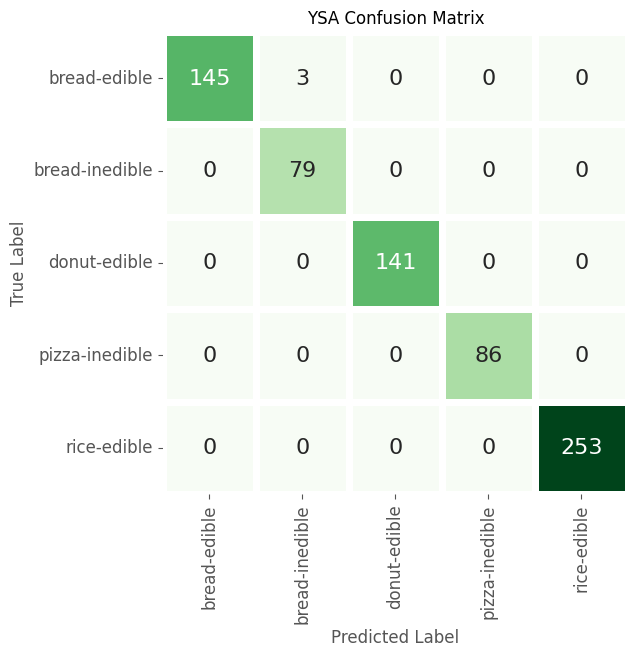

In [24]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=['bread-edible', 'bread-inedible','donut-edible', 'pizza-inedible', 'rice-edible'], index= ['bread-edible', 'bread-inedible','donut-edible', 'pizza-inedible', 'rice-edible'], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [25]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.992683


In [26]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.995946


In [27]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.994226


In [29]:
def Prediction(test_image):

    global width, height, files, labels

    img = image.img_to_array(test_image)
    img = np.expand_dims(img, axis=0)
    img = img/255.0
    
    class_list = ['bread-edible', 'bread-inedible','donut-edible', 'pizza-inedible', 'rice-edible'] 
    
    pred = model.predict(img)
    predicted_class = class_list[np.argmax(pred[0])]
    return predicted_class

1/1 [==============================] - 0s 37ms/step


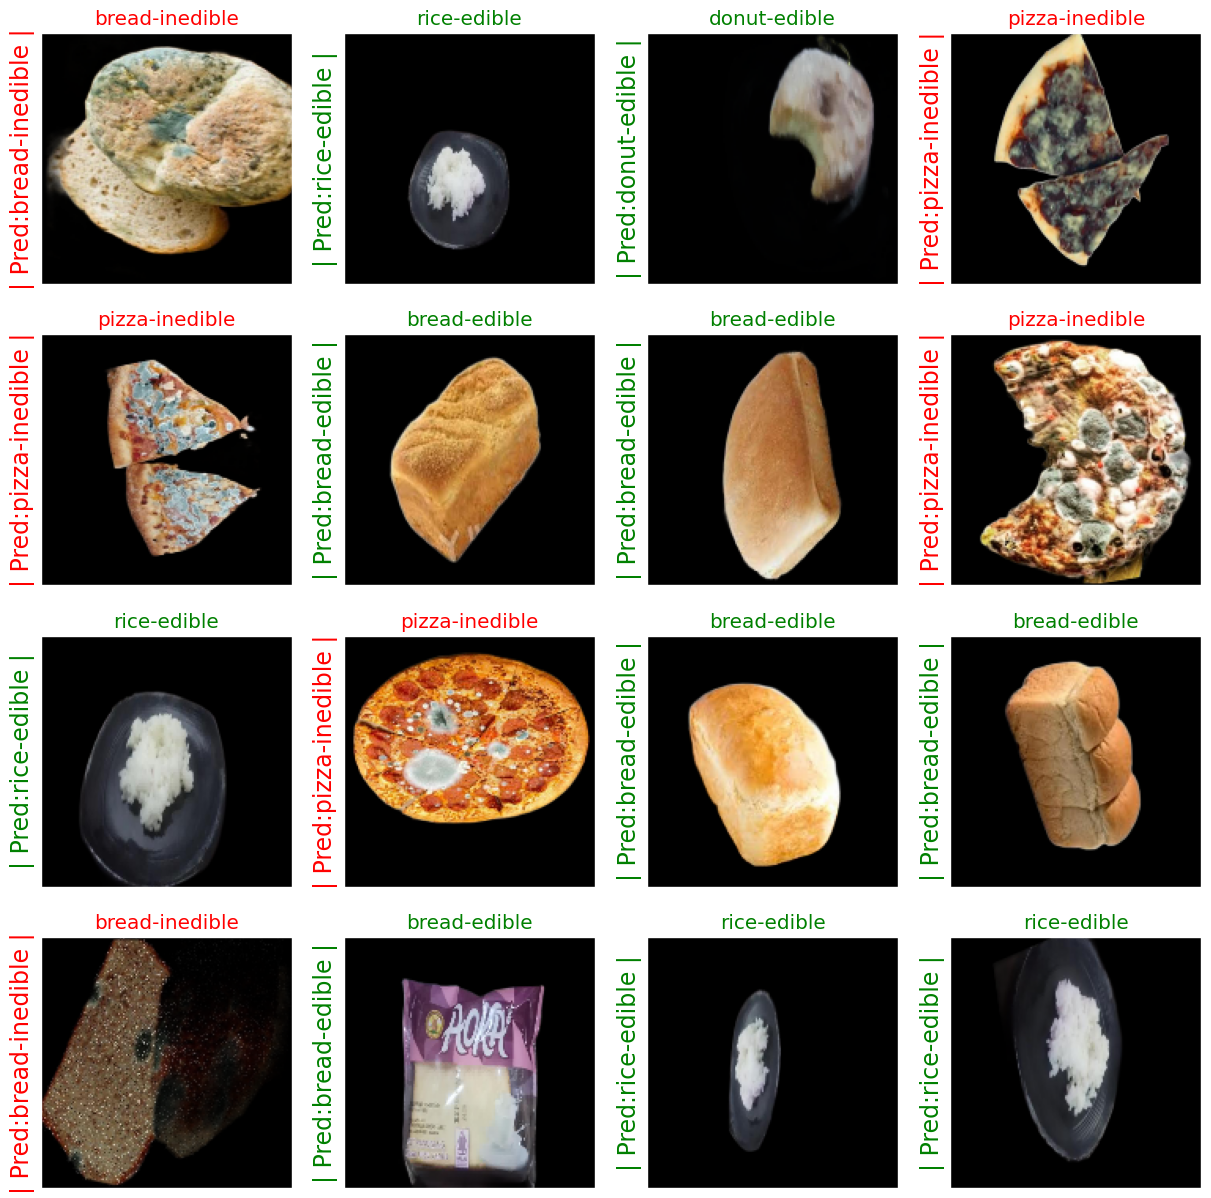

In [30]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if '-edible' in image_target[fig]:
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

1/1 [==============================] - 0s 44ms/step
Rentang hasil prediksi:
Nilai Minimum: 0.014018618
Nilai Maksimum: 0.3302852
This Image belongs to class donut-edible


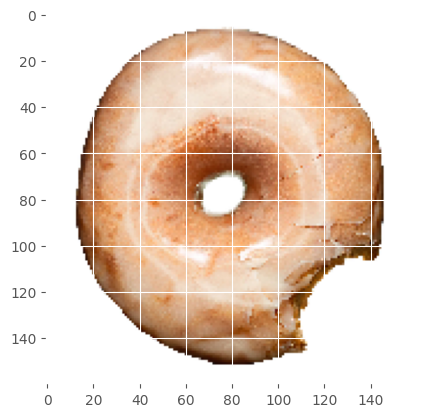

In [41]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras import utils
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk


#function to call the upload file dialog box
def upload_file():
    global img, predict_path
    f_types = [('Jpg Files', '*.jpg',), ('Png Files', '*.png'), ('All Files', '*.*')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    predict_path = filename
    img = ImageTk.PhotoImage(file=filename)
    my_w.destroy()

my_w = tk.Tk()
my_w.geometry("400x300")  
my_w.title('testing')
my_font1=('times', 18, 'bold')
l1 = tk.Label(my_w,text='test your food',width=30,font=my_font1)  
l1.grid(row=1,column=1)
b1 = tk.Button(my_w, text='Upload File', 
   width=20,command = lambda:upload_file())
b1.grid(row=2,column=1) 

my_w.mainloop()

img = image.load_img(predict_path, target_size=(160, 160))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalisasi gambar seperti saat melatih model

# Melakukan prediksi
classes = model.predict(x, batch_size=1)
nilai_min = np.min(classes)
nilai_max = np.max(classes)

print("Rentang hasil prediksi:")
print("Nilai Minimum:", nilai_min)
print("Nilai Maksimum:", nilai_max)

class_list = ['bread-edible', 'bread-inedible','donut-edible', 'pizza-inedible', 'rice-edible']

predicted_class = class_list[np.argmax(classes[0])]
print('This Image belongs to class', predicted_class)

In [36]:
model.save('model.h5')